# Face Recogniction CNN Model

## 0. Importing PyTorch Modules and setting up device

In [1]:
import os
import torch
import helper_funcs as hlp
from pathlib import Path
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__, device


c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.3.1+cu121', 'cuda')

## 1. Load Dataset

In [2]:
# Determine Image Size
IMAGE_X = 64
IMAGE_Y = 64
IMAGE_SIZE = (IMAGE_X, IMAGE_Y)

# Set Train and Test Directories
root_dir  = Path('pizza_steak_sushi')
train_dir = root_dir / "train"
test_dir  = root_dir / 'test'


# Define Image Transformer
simple_transform = transforms.Compose([transforms.Resize(size=IMAGE_SIZE), transforms.ToTensor()])

# Get Train and Test data
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

## 2. Visualize Data

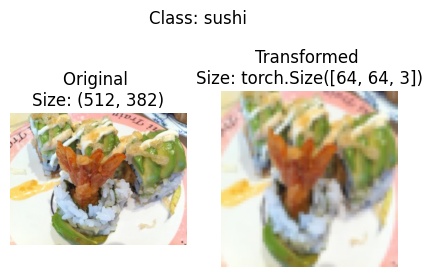

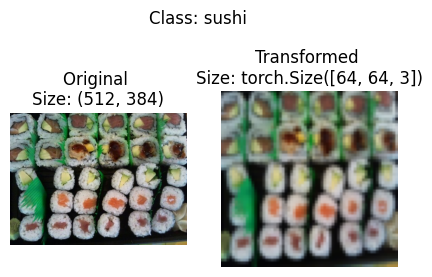

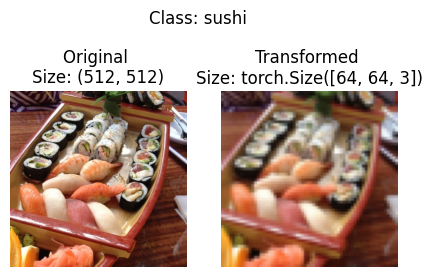

In [3]:
# Create Image List
images_list = list(root_dir.glob("*/*/*.jpg"))
images_list.extend(root_dir.glob("*/*/*.jpeg"))


# Plot Images after transforming
hlp.plot_transformed_images(image_paths=images_list, transform=simple_transform, n=3)

## 3. Group Data to batches

In [4]:
# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = 15

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x1a418f18cb0>,
 <torch.utils.data.dataloader.DataLoader at 0x1a417c87380>)

## 4. Design Model

In [5]:
IN_CHANNELS     = 3   # Color Channels
HIDDEN_UNITS    = 10
OUTPUT_SHAPE = len(train_data_simple.classes)

simple_model = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=HIDDEN_UNITS, kernel_size=3, stride=1,  padding=1), 
    nn.ReLU(),
    nn.Conv2d(in_channels=HIDDEN_UNITS, out_channels=HIDDEN_UNITS, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=HIDDEN_UNITS*16*16, out_features=OUTPUT_SHAPE)
).to(device)

simple_model

Sequential(
  (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=2560, out_features=3, bias=True)
)

In [6]:
# Verify Model using torchinfo.summary
summary(simple_model, input_size=[1, 3, IMAGE_X, IMAGE_Y])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3]                    --
├─Conv2d: 1-1                            [1, 10, 64, 64]           280
├─ReLU: 1-2                              [1, 10, 64, 64]           --
├─Conv2d: 1-3                            [1, 10, 64, 64]           910
├─ReLU: 1-4                              [1, 10, 64, 64]           --
├─MaxPool2d: 1-5                         [1, 10, 32, 32]           --
├─Conv2d: 1-6                            [1, 10, 32, 32]           910
├─ReLU: 1-7                              [1, 10, 32, 32]           --
├─Conv2d: 1-8                            [1, 10, 32, 32]           910
├─ReLU: 1-9                              [1, 10, 32, 32]           --
├─MaxPool2d: 1-10                        [1, 10, 16, 16]           --
├─Flatten: 1-11                          [1, 2560]                 --
├─Linear: 1-12                           [1, 3]                    7,683
Total pa

## 5. Train Model

In [7]:
# Number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=0.01)

simple_model_results = hlp.train_model(model=simple_model, train_dataloader=train_dataloader_simple, test_dataloader=test_dataloader_simple, 
                                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, device=device)

 10%|█         | 1/10 [00:19<02:58, 19.81s/it]

Epoch: 1 | train_loss: 1.1207 | train_acc: 0.4258 | test_loss: 1.0971 | test_acc: 0.2604


 20%|██        | 2/10 [00:39<02:36, 19.54s/it]

Epoch: 2 | train_loss: 1.1002 | train_acc: 0.3047 | test_loss: 1.0982 | test_acc: 0.2604


 30%|███       | 3/10 [00:58<02:16, 19.55s/it]

Epoch: 3 | train_loss: 1.1055 | train_acc: 0.3047 | test_loss: 1.0943 | test_acc: 0.2604


 40%|████      | 4/10 [01:18<01:58, 19.67s/it]

Epoch: 4 | train_loss: 1.0988 | train_acc: 0.3047 | test_loss: 1.0958 | test_acc: 0.2604


 50%|█████     | 5/10 [01:38<01:38, 19.68s/it]

Epoch: 5 | train_loss: 1.0969 | train_acc: 0.3047 | test_loss: 1.0917 | test_acc: 0.5417


 60%|██████    | 6/10 [01:57<01:18, 19.61s/it]

Epoch: 6 | train_loss: 1.0989 | train_acc: 0.2812 | test_loss: 1.0870 | test_acc: 0.5417


 70%|███████   | 7/10 [02:17<00:58, 19.58s/it]

Epoch: 7 | train_loss: 1.1054 | train_acc: 0.2812 | test_loss: 1.0887 | test_acc: 0.5417


 80%|████████  | 8/10 [02:36<00:39, 19.56s/it]

Epoch: 8 | train_loss: 1.0972 | train_acc: 0.4141 | test_loss: 1.0947 | test_acc: 0.2604


 90%|█████████ | 9/10 [02:56<00:19, 19.55s/it]

Epoch: 9 | train_loss: 1.1025 | train_acc: 0.3047 | test_loss: 1.1009 | test_acc: 0.2604


100%|██████████| 10/10 [03:15<00:00, 19.57s/it]

Epoch: 10 | train_loss: 1.0991 | train_acc: 0.3047 | test_loss: 1.1087 | test_acc: 0.2604


## 6. Evaluate Model

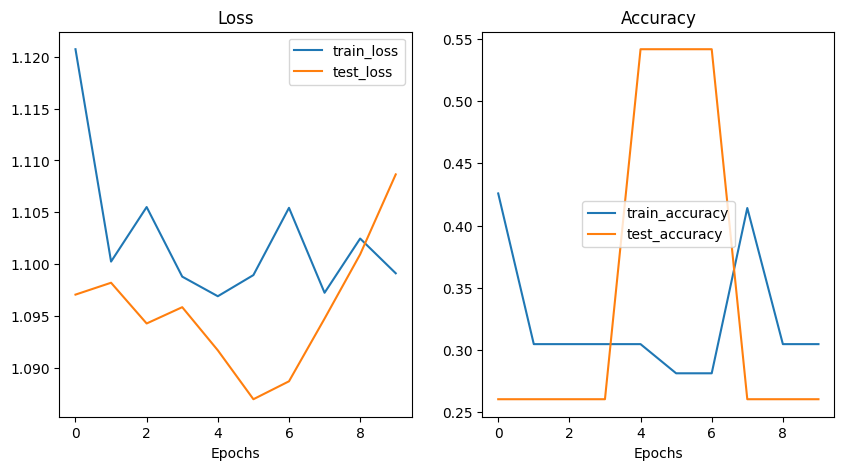

In [8]:
hlp.plot_loss_curves(simple_model_results)

## 7. Predict using custom data

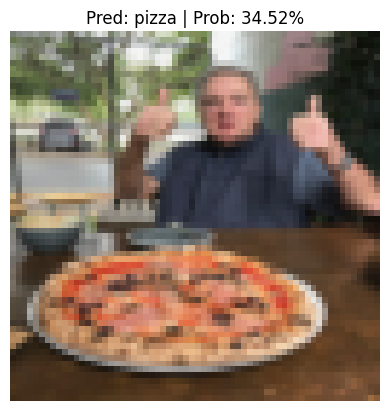

In [9]:
# Pred on our custom image
test_img = '04-pizza-dad.jpeg'
IMAGE_PATH_EXTRA = Path(root_dir) / test_img
class_names = train_data_simple.classes
custom_image_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),])

hlp.pred_and_plot_image(model=simple_model, image_path=IMAGE_PATH_EXTRA, class_names=class_names, transform=custom_image_transform, device=device)